In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
import pandas as pd
from codex import io as codex_io
from codex import config as codex_config
from skimage import exposure
from skimage import io as sk_io
plt.gray()
SEED=5512
None

In [15]:
# exp_name = '7-7-17-multicycle'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-cytokit', 'output', 'v01')
# nuc_midx = 7
# nuc_ch_name = 'ci:HOECHST1'

exp_name = '2018-01-09-Run0'
exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name + '-Clean', 'output', 'v00')
nuc_midx = 6
nuc_ch_name = 'ci:HOECHST1'

# exp_name = '20180706-Donor22-R2-Tcell-CODEX_CD3CD4CD85BY5'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01')
# nuc_midx = 5
# nuc_ch_name = 'ci:DAPI'

# exp_name = '20180614_D23_RepA_Tcell_CD4-CD8-DAPI_5by5'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v03')
# nuc_midx = 5
# nuc_ch_name = 'ci:DAPI'

# exp_name = '20180802-Donor7_Tcell-CODEX_CD3CD4CD8_7BYB7'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v02')
# nuc_midx = 5
# nuc_ch_name = 'ci:DAPI'

# exp_name = 'RS002_CODEX_Tonsil_180426'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', 'wherrylab', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'wherrylab', exp_name, '2018_08_02_RS002_processed_cytokit', 'output', 'v01')
# nuc_midx = 6
# nuc_ch_name = 'ci:HOECHST2'

In [16]:
config = codex_config.load(exp_conf_dir)

In [17]:
#img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'hoechst'))
img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'best_z_segm'))
img_path

'/lab/data/2018-01-09-Run0-Clean/output/v00/montage/best_z_segm/R001.tif'

In [18]:
img = codex_io.read_tile(img_path)
img.shape

(1, 1, 7, 5040, 6720)

In [19]:
df = pd.read_csv(osp.join(exp_data_dir, codex_io.get_cytometry_agg_path('csv')))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33820 entries, 0 to 33819
Data columns (total 43 columns):
region_index         33820 non-null int64
tile_index           33820 non-null int64
tile_x               33820 non-null int64
tile_y               33820 non-null int64
rid                  33820 non-null int64
rx                   33820 non-null float64
ry                   33820 non-null float64
id                   33820 non-null int64
x                    33820 non-null float64
y                    33820 non-null float64
z                    33820 non-null int64
cell_size            33820 non-null float64
cell_diameter        33820 non-null float64
cell_perimeter       33820 non-null float64
cell_solidity        33820 non-null float64
nucleus_size         33820 non-null float64
nucleus_diameter     33820 non-null float64
nucleus_perimeter    33820 non-null float64
nucleus_solidity     33820 non-null float64
ci:HOECHST1          33820 non-null float64
ci:CollagenIV        3382

In [20]:
df['region_index'].value_counts()

0    33820
Name: region_index, dtype: int64

In [21]:
df = df[df['region_index'] == 0]
len(df)

33820

In [22]:
df[['cell_size', nuc_ch_name]].hist(figsize=(12, 4), bins=128)
None

In [23]:
from sklearn.preprocessing import PolynomialFeatures

def filter_by_pct(df, features, percents):
    ranges = df[features].quantile(q=percents)

    # Stack masks horizontally as dataframe
    print(ranges)
    mask = pd.concat([
        df[c].between(ranges[c].iloc[0], ranges[c].iloc[1])
        for c in ranges
    ], axis=1)
    
    return df[mask.all(axis=1).values]

def clip_by_pct(df, features, percents):
    ranges = df[features].quantile(q=percents)
    print(ranges)
    for c in ranges:
        df[c] = df[c].clip(ranges[c].iloc[0], ranges[c].iloc[1])
    return df

filter_features = ['cell_size', nuc_ch_name]
#clip_features = [nuc_ch_name]
#filter_features = ['cell_size']
#filter_range = [.01, .99]
filter_range = [.01, .99]
#filter_range = [.001, .999]
#filter_range = [0., 1.]
max_cells = 500000
mode = 'local'

dfm = df.copy()
dfm = filter_by_pct(dfm, filter_features, filter_range)
#dfm = clip_by_pct(dfm, clip_features, filter_range)
if len(dfm) > max_cells:
    dfm = dfm.sample(n=max_cells, random_state=SEED)
            
cols = ['y', 'x'] if mode == 'local' else ['ry', 'rx']
X, y = dfm[cols].copy(), dfm[nuc_ch_name] / dfm[nuc_ch_name].mean()

X.columns

       cell_size  ci:HOECHST1
0.01   17.522883    11.061615
0.99  258.827228   103.110524


Index(['y', 'x'], dtype='object')

In [24]:
if mode == 'global':
    plt.hexbin(X['rx'], img.shape[-2] - X['ry'], gridsize=100)
    plt.gcf().set_size_inches(12, 12)

In [234]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.pipeline import Pipeline

est = Pipeline([
    ('feat', PolynomialFeatures(degree=2)),
    ('est', LinearRegression())
])
#est = GradientBoostingRegressor(n_estimators=1, random_state=SEED)
#est = GradientBoostingRegressor(n_estimators=100, random_state=SEED)#, min_samples_leaf=10)
# def weight_fn(distances):
#     print(distances.dtype, distances.shape)
#     #return np.where(distances > 500, 0., 1/distances)
#     return np.where(distances > 1000, 0., 1.)
#est = KNeighborsRegressor(n_neighbors=500, weights=weight_fn)
#est = RadiusNeighborsRegressor(radius=100, weights='distance')
#est = DecisionTreeRegressor(random_state=SEED)
est.fit(X, y)

Pipeline(memory=None,
     steps=[('feat', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('est', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [235]:
#pd.Series(est.coef_, X.columns)

In [236]:
from skimage import transform

def get_pred_image(est, shape, step=1):
    r, c = shape
    ri, ci = np.arange(0, r, step), np.arange(0, c, step)
    ii = np.transpose([np.repeat(ri, len(ci)), np.tile(ci, len(ri))])
    X = pd.DataFrame(ii, columns=['ry', 'rx'])
    
    yp = est.predict(X)
    yp = np.where(np.isnan(yp), 1., yp)
    yp = yp.reshape((len(ri), len(ci)))

    if step > 1:
        print('Resizing')
        yp = transform.resize(yp, shape, mode='constant', order=1, anti_aliasing=False, preserve_range=False)
        
    assert yp.shape == (r, c)
    return yp

In [237]:
if mode == 'local':
    shape = config.tile_height, config.tile_width
else:
    shape = config.region_height * config.tile_height, config.region_width * config.tile_width
yp = get_pred_image(est, shape, step=10)

Resizing


In [238]:
yp.shape, img.shape[-2:]

((1008, 1344), (5040, 6720))

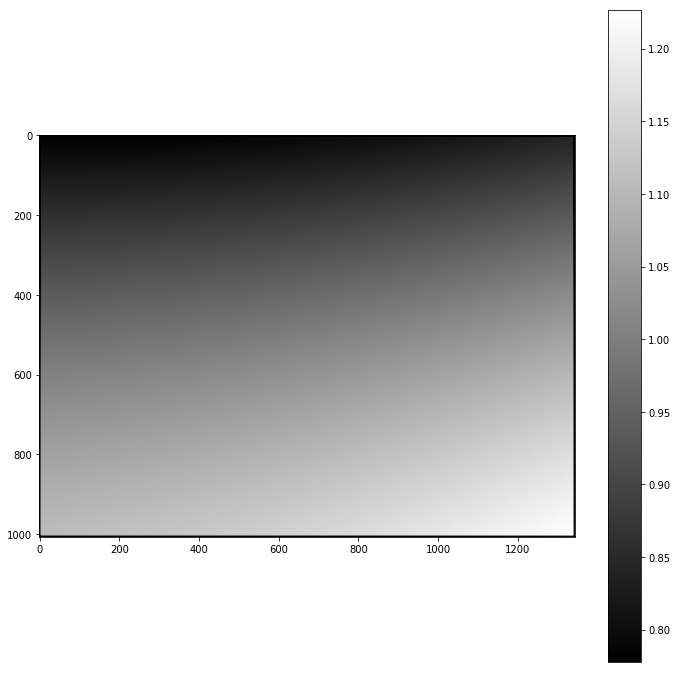

In [239]:
plt.imshow(yp)
plt.colorbar()
plt.gcf().set_size_inches(12, 12)

In [240]:
yc = yp
if mode == 'local':
    yc = np.hstack(tuple([yc] * config.region_width))
    yc = np.vstack(tuple([yc] * config.region_height))
yc.shape, img.shape[-2:]

((5040, 6720), (5040, 6720))

In [52]:
# plt.set_cmap('viridis')

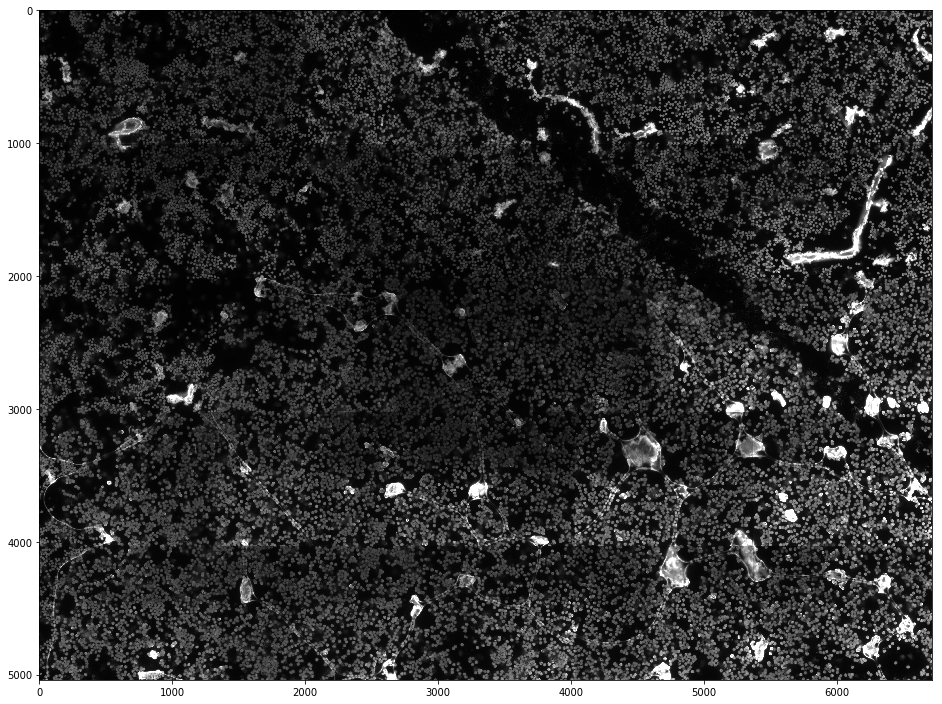

In [245]:
img_orig = img[0, 0, nuc_midx]
plt.imshow(img_orig.clip(0, 10000))
# plt.imshow(img_orig)
plt.gcf().set_size_inches(16, 16)

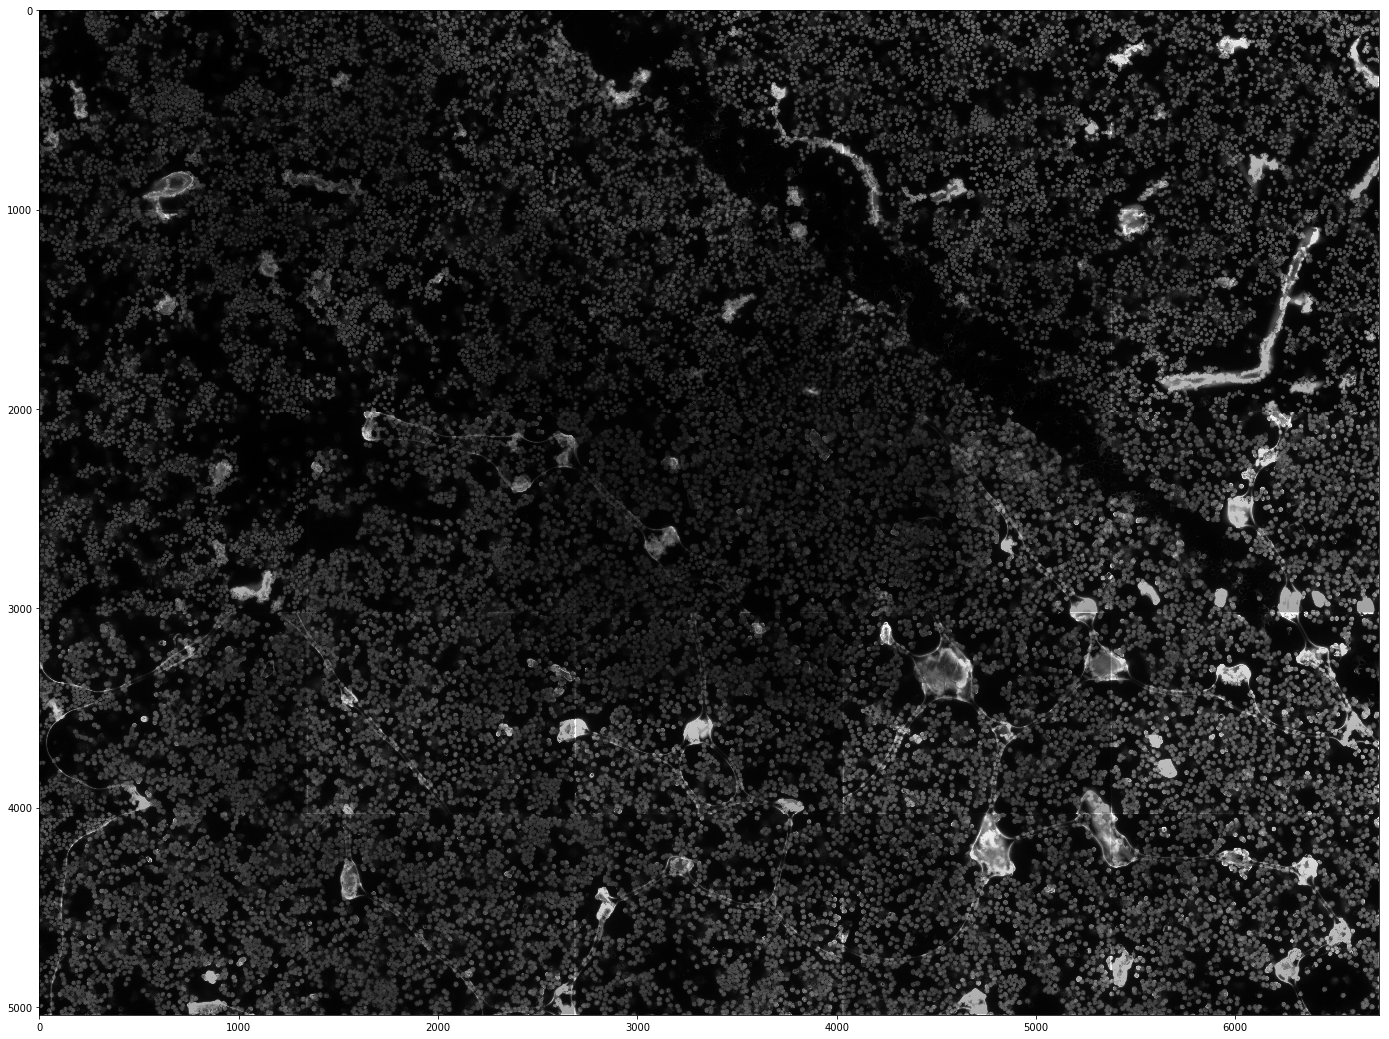

In [242]:
img_ic = img[0, 0, nuc_midx] / yc
#plt.imshow(img_ic)
plt.imshow(img_ic.clip(0, 10000))
plt.gcf().set_size_inches(24, 24)